# **Data-Driven Business Insights into Asia’s Economic Outlook on U.S. Tariff Policy**

In [25]:
!pip install requests beautifulsoup4 vaderSentiment pandas matplotlib seaborn nltk wordcloud
!pip install streamlit

In [56]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import time
import streamlit as st
from bs4 import BeautifulSoup
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
from wordcloud import WordCloud

In [57]:
# Setup NLTK
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
# Use User-Agents rotate (different browser signature for each request) so it hard to detect our web scraper
user_agentsrot = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 Chrome/120.0",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 Safari/537.36",
    "Mozilla/5.0 (X11; Linux x86_64) Gecko/20100101 Firefox/112.0",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:106.0) Gecko/20100101 Firefox/106.0"
]

def get_random_headers():
    return {
        "User-Agent": random.choice(user_agentsrot),
        "Accept-Language": "en-US,en;q=0.9",
        "Referer": "https://www.google.com/",
        "Connection": "keep-alive"
    }

In [61]:
# Web Scraping for Aljazeera
def get_aljazeera_links():
    base_urls = [
        "https://www.aljazeera.com/news/asia-pacific",
        "https://www.aljazeera.com/economy",
        "https://www.aljazeera.com/tag/us-china-trade-war"
    ]

    all_links = []
    for base_url in base_urls:
        for page in range(1, 4):  # up to 3 pages per section
            url = base_url + f"/?page={page}"
            try:
                res = requests.get(url, headers=get_random_headers())
                soup = BeautifulSoup(res.text, 'html.parser')
                raw_links = [
                    "https://www.aljazeera.com" + a['href']
                    for a in soup.find_all('a', href=True)
                    if a['href'].startswith('/news/') and "live" not in a['href']
                ]
                filtered = [
                    link for link in raw_links
                    if any(k in link.lower() for k in ["asia", "economy", "tariff", "trade", "us", "china"])
                ]
                all_links.extend(filtered)
            except Exception as e:
                print(f"Error scraping {url}: {e}")

    return list(set(all_links))[:100]

In [62]:
def get_cnn_links():
    url = "https://edition.cnn.com/world/asia"
    res = requests.get(url, headers=get_random_headers())
    soup = BeautifulSoup(res.text, 'html.parser')

    raw_links = [
        "https://edition.cnn.com" + a['href']
        for a in soup.find_all('a', href=True)
        if a['href'].startswith("/") and "/videos" not in a['href'] and "/live-news" not in a['href']
    ]

    filtered_links = [
        link for link in raw_links
        if any(k in link.lower() for k in ["asia", "economy", "tariff", "trade", "us", "china"])
    ]

    return list(set(filtered_links))[:50]

In [63]:
def extract_article_text(url):
    try:
        res = requests.get(url, headers=get_random_headers(), timeout=10)
        soup = BeautifulSoup(res.text, 'html.parser')
        title = soup.title.get_text() if soup.title else ""
        paragraphs = soup.find_all('p')
        body = " ".join(p.get_text() for p in paragraphs)
        return title + "\n" + body
    except:
        return ""

In [64]:
#Sentiment Analysis
def analyze_articles(links, source_name):
    analyzer = SentimentIntensityAnalyzer()
    keywords = ["tariff", "trade", "import", "export", "us", "u.s.", "sanction", "economy", "china"]
    results = []

    for link in links:
        text = extract_article_text(link)
        if len(text.strip().split()) < 100:
            continue
        keyword_hits = sum(1 for k in keywords if k in text.lower())
        if keyword_hits < 1:
            continue
        sentiment = analyzer.polarity_scores(text)
        results.append({
            "Source": source_name,
            "URL": link,
            "Content": text,
            "Compound": sentiment['compound'],
            "Positive": sentiment['pos'],
            "Neutral": sentiment['neu'],
            "Negative": sentiment['neg']
        })

    return results

In [65]:
# Run the Analysis based on the data that we got after the web scraping
cnn_data = analyze_articles(get_cnn_links(), "CNN")
aljazeera_data = analyze_articles(get_aljazeera_links(), "Al Jazeera")

# Combine
final_data = pd.DataFrame(cnn_data + aljazeera_data)
final_data.to_csv("sentiment_scores.csv", index=False)
final_data.head()

,Source,URL,Content,Compound,Positive,Neutral,Negative
0,CNN,https://edition.cnn.com/2025/05/05/asia/japan-...,Japan’s former Emperor Akihito to be hospitali...,0.9201,0.081,0.899,0.020
1,CNN,https://edition.cnn.com/2025/04/22/asia/gunmen...,"Pahalgam, India: At least 26 people killed as ...",-0.9998,0.056,0.767,0.178
2,CNN,https://edition.cnn.com/2025/05/02/asia/singap...,Singapore votes in test of ruling party’s mono...,0.9950,0.156,0.775,0.068
3,CNN,https://edition.cnn.com/2025/03/28/india/india...,India among top suppliers of illicit fentanyl ...,0.9702,0.087,0.861,0.052
4,CNN,https://edition.cnn.com/2025/04/28/europe/ukra...,"Putin thanks North Korea for help in Kursk, as...",0.9593,0.079,0.864,0.057


<ipython-input-66-6527572dcd36>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=final_data, x="Source", y="Compound", palette="Set2")


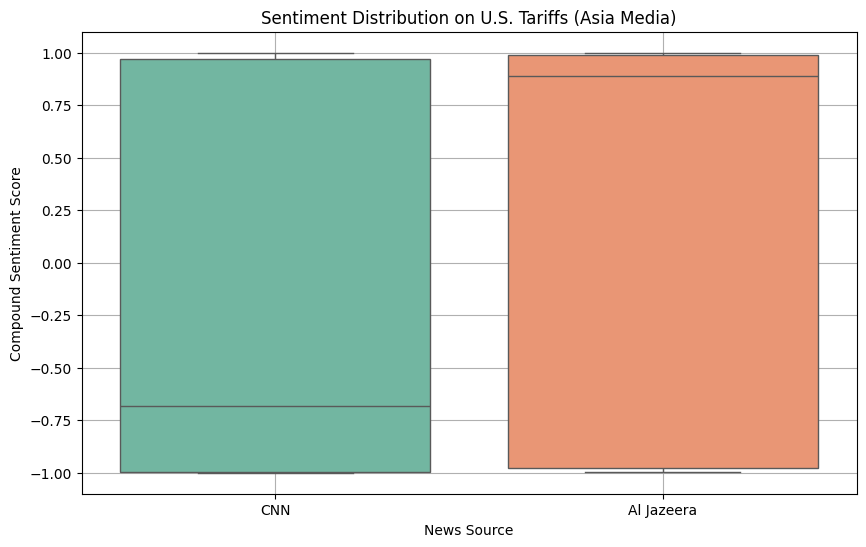

In [66]:
#Distribution Plot of The Sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_data, x="Source", y="Compound", palette="Set2")
plt.title("Sentiment Distribution on U.S. Tariffs (Asia Media)")
plt.xlabel("News Source")
plt.ylabel("Compound Sentiment Score")
plt.grid(True)
plt.show()

In [67]:
print(final_data["Source"].value_counts())
final_data = pd.DataFrame(cnn_data + aljazeera_data)

Source
CNN           34
Al Jazeera    11
Name: count, dtype: int64


In [68]:
# Keyword Frequency
all_text = " ".join(final_data["Content"].str.lower())
words = all_text.translate(str.maketrans('', '', string.punctuation)).split()
filtered_words = [w for w in words if w not in stop_words and len(w) > 3]
word_freq = Counter(filtered_words)
keyword_df = pd.DataFrame(word_freq.most_common(20), columns=["Keyword", "Frequency"])
keyword_df.to_csv("keyword_freq.csv", index=False)

In [79]:
app_code = """
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from wordcloud import WordCloud
from collections import Counter
import string

# Load data
df = pd.read_csv("sentiment_scores.csv")
keyword_df = pd.read_csv("keyword_freq.csv")

# Streamlit Page Setup
st.set_page_config(page_title="Asia’s Economic Outlook on U.S. Tariff Policy", layout="wide")
st.title("📈 Data-Driven Business Insights into Asia’s Economic Outlook on U.S. Tariff Policy")

st.markdown(\"\"\"
This dashboard analyzes how Asia-based news media frames U.S. tariff policies using sentiment scoring and keyword analysis.
It delivers business-relevant insights that reflect **regional market sentiment** and help identify potential risks and opportunities.
\"\"\")

# Filter by Source
sources = st.sidebar.multiselect("📌 Filter by Source", df["Source"].unique(), default=df["Source"].unique())
filtered_df = df[df["Source"].isin(sources)]

# 1. Sentiment Table
st.subheader("1. Sentiment Scores")
st.dataframe(filtered_df[["Source", "URL", "Compound", "Positive", "Neutral", "Negative"]])

# 2. Sentiment Boxplot
st.subheader("2. Sentiment Distribution by Source")
fig1, ax1 = plt.subplots()
sns.boxplot(data=filtered_df, x="Source", y="Compound", palette="Set2", ax=ax1)
st.pyplot(fig1)

# Average Scores Table
st.markdown("**📊 Average Compound Score per Source**")
st.dataframe(filtered_df.groupby("Source")["Compound"].mean().reset_index())

# 3. Keyword Frequency
st.subheader("3. Top 20 Keywords")
fig2, ax2 = plt.subplots()
sns.barplot(data=keyword_df.head(20), x="Frequency", y="Keyword", palette="viridis", ax=ax2)
st.pyplot(fig2)

# 4. Word Cloud
st.subheader("4. Word Cloud")
all_text = " ".join(df["Content"].astype(str)).lower()
words = all_text.translate(str.maketrans('', '', string.punctuation)).split()
stopwords = set([
    "said", "would", "could", "also", "one", "new", "us", "u.s.", "get", "year",
    "news", "reuters", "aljazeera", "cnn", "say", "make", "like", "may", "asia", "amp"
])
filtered_words = [w for w in words if w not in stopwords and len(w) > 3]
word_freq = Counter(filtered_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq))
fig3, ax3 = plt.subplots(figsize=(15, 7))
ax3.imshow(wordcloud, interpolation='bilinear')
ax3.axis('off')
st.pyplot(fig3)

"""

In [80]:
# Save to streamlit.py
with open("streamlit.py", "w") as f:
    f.write(app_code)

In [81]:
# Download streamlit.py
from google.colab import files
files.download("streamlit.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>